# Notebook overview

# Imports
## Libraries

In [693]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import gc, warnings, os, time
import mlflow
import importlib

# custom classes
import pipelines
import data_preprocessing as process
import transformers

importlib.reload(process)
importlib.reload(transformers)
importlib.reload(pipelines)

from transformers import ApplicationCleaner
from pipelines import PIPELINES, DEFAULT_CONFIG

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, fbeta_score, roc_curve, RocCurveDisplay, confusion_matrix, recall_score, precision_score

from imblearn.over_sampling import SMOTE

warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:.4f}'.format

# Pipeline

### Custom score function

Every outcome of a confusion matrix has its own cost:

**TP:** Customers identified as risky and who actually had payment difficulties. <br/>
**TN:** Customers identified as safe and who really didn't have payment issues. <br/>
**FP:** Customers identified as risky but who actually don't have payment difficulties. They represent potential clients that are lost. <br/>
**FN:** Customers identified as safe but who did have payment issues. These clients are the most costly for the bank and their number should be minimized. <br/>

There is a trade-off between False Negatives and False Positives, both represent money lost for the company. However, the False Negative will have more financial impact, so more weight should be attributed to them. We will use the following formula for the custom score function: `10*FN + FP` that will give us a score to minimize.

In [705]:
def get_custom_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    #print(f'TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}')
    score = 10*fn + fp

    #print(score)
    return score/y_true.size

In [694]:
def display_scores(y_true, y_pred, y_pred_proba, name=''):
    metrics = {
        'AUC': round(roc_auc_score(y_true, y_pred), 2),
        'Custom': round(get_custom_score(y_true, y_pred), 2),
        'Recall': round(recall_score(y_true, y_pred), 2),
        'Precision': round(precision_score(y_true, y_pred), 2),
        'F beta 10': round(fbeta_score(y_true, y_pred, beta=10), 2),
        'Accuracy': round(accuracy_score(y_true, y_pred, normalize=True), 2),
    }
    
    print('-------------------------')

    for metric_name in metrics:
        print(f'{metric_name}: {metrics[metric_name]}')
        mlflow.log_metric(metric_name, metrics[metric_name])

    # Classification report
    print('Classification report:')
    print(f'{classification_report(y_true, y_pred, zero_division=0)}')

    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    auc = roc_auc_score(y_true, y_pred_proba)

    #create ROC curve
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name=name)
    display.plot()
    
    print('-------------------------')

### Training

In [531]:
def train(pipeline_name, config, dev_mode=True):
    print('Training the model')
    time_start = time.time()

    data = process.load_data(dev_mode)

    X = data['application'].drop(process.TARGET_COLUMN, axis=1)
    y = data['application'][process.TARGET_COLUMN]

    X_train, X_test, y_train, y_test = train_test_split(X,
                                                          y,
                                                          test_size=0.2,
                                                          random_state=42,
                                                          shuffle=False)

    print('Train shape: {}'.format(X_train.shape))
    print('Valid shape: {}'.format(y_train.shape))

    pipeline = PIPELINES[pipeline_name](config=config, dev_mode=dev_mode)

    print('Start pipeline fit and transform')
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[::,1]

    display_scores(y_test, y_pred, y_pred_proba, name=pipeline_name)

    mlflow.sklearn.log_model(pipeline, pipeline_name)
    
    exec_time = round((time.time() - time_start), 2)
    print(f'execution time: {exec_time} seconds \n')

In [658]:
# debug
test_config = {
    'preprocessing': {
        'should_fill_na': False,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': StandardScaler(),
        'use_bureau_and_balance': False,
        'use_previous_applications': True
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42
    }
}

time_start = time.time()

data = process.load_data(dev_mode=False)

X = data['application'].drop(process.TARGET_COLUMN, axis=1)
y = data['application'][process.TARGET_COLUMN]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                      y,
                                                      test_size=0.2,
                                                      random_state=42,
                                                      shuffle=False)

print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(y_train.shape))

pipeline = PIPELINES['log_regression'](config=test_config, dev_mode=False)


X_new = pipeline.fit(X_train)
X_new_test = pipeline.transform(X_test)
X_new_test.head(10)

Loading application_train ...
Loading Done.
Train shape: (246008, 121)
Valid shape: (246008,)


2023/11/17 11:44:34 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e04cebeefbd84ff2bf804d0d8ece7b7c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


prev app shape (338857, 249)


2023/11/17 11:44:34 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_previous_applications',
                 ApplicationFeaturesMerger(features_to_merge=            PREV_AMT_ANNUITY_MIN  PREV_AMT_ANNUITY_MAX  PREV_AMT_ANNUITY_MEAN  \
SK_ID_CURR                                                                      
100001                 3951.0000             3951.0000              3951.0000   
10000...`
2023/11/17 11:44:35 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_previous_applications',
                 ApplicationFeaturesMerger(features_to_merge=            PREV_AMT_ANNUITY_MIN  PREV_AMT_ANNUITY_MAX  PREV

[Pipeline] ........... (step 1 of 3) Processing cleaner, total=   0.7s
[Pipeline] . (step 2 of 3) Processing feature_extractor, total=   0.0s
[Pipeline]  (step 3 of 3) Processing merge_previous_applications, total=   0.0s
[Pipeline] ...... (step 1 of 1) Processing preprocessor, total=   0.7s


2023/11/17 11:44:39 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/11/17 11:44:39 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


shape before  (5, 128)
new shape after merge (5, 377)


2023/11/17 11:44:39 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


shape before  (61503, 128)
new shape after merge (61503, 377)


2023/11/17 11:44:42 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,REFUSED_HOUR_APPR_PROCESS_START_MAX,REFUSED_HOUR_APPR_PROCESS_START_MEAN,REFUSED_RATE_DOWN_PAYMENT_MIN,REFUSED_RATE_DOWN_PAYMENT_MAX,REFUSED_RATE_DOWN_PAYMENT_MEAN,REFUSED_DAYS_DECISION_MIN,REFUSED_DAYS_DECISION_MAX,REFUSED_DAYS_DECISION_MEAN,REFUSED_CNT_PAYMENT_MEAN,REFUSED_CNT_PAYMENT_SUM
246008,384696,Cash loans,F,0,1,1,180000.0000,545040.0000,36553.5000,450000.0000,...,10.0000,10.0000,NaN,NaN,NaN,-7.0000,-7.0000,-7.0000,24.0000,24.0000
246009,384697,Cash loans,F,1,1,1,337500.0000,790830.0000,62613.0000,675000.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246010,384698,Cash loans,F,0,1,1,63000.0000,310500.0000,15232.5000,310500.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246011,384699,Cash loans,F,0,0,0,112500.0000,942300.0000,36643.5000,675000.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246012,384700,Cash loans,F,1,1,0,180000.0000,272520.0000,19957.5000,225000.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246013,384701,Cash loans,F,1,0,1,112500.0000,163332.0000,8469.0000,117000.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246014,384702,Cash loans,M,1,1,0,225000.0000,781920.0000,32998.5000,675000.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246015,384703,Cash loans,F,0,1,1,67500.0000,59301.0000,4257.0000,49500.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246016,384704,Cash loans,M,0,0,0,675000.0000,167895.0000,17626.5000,157500.0000,...,10.0000,10.0000,NaN,NaN,NaN,-620.0000,-616.0000,-618.0000,60.0000,120.0000
246017,384705,Cash loans,F,0,1,1,202500.0000,270000.0000,9828.0000,270000.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Training the model
Loading application_train ...
Loading Done.
Train shape: (4000, 121)
Valid shape: (4000,)


2023/11/20 14:53:57 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/11/20 14:53:57 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2023/11/20 14:53:57 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


Start pipeline fit and transform
[Pipeline] ........... (step 1 of 8) Processing cleaner, total=   0.0s
[Pipeline] . (step 2 of 8) Processing feature_extractor, total=   0.0s
shape before  (4000, 128)
new shape after merge (4000, 244)
[Pipeline]  (step 3 of 8) Processing merge_bureau_and_balance, total=   0.0s
[Pipeline] ........... (step 4 of 8) Processing imputer, total=   0.1s
[Pipeline] ............ (step 5 of 8) Processing scalar, total=   0.0s
[Pipeline] ........... (step 6 of 8) Processing encoder, total=   0.0s
[Pipeline] ............. (step 7 of 8) Processing smote, total=   1.7s


2023/11/20 14:53:59 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: 

[Pipeline] ........ (step 8 of 8) Processing classifier, total=   1.7s
shape before  (1000, 128)
new shape after merge (1000, 244)
shape before  (1000, 128)
new shape after merge (1000, 244)
TN: 0, FP: 920, FN: 0, TP: 80
920
-------------------------
AUC: 0.5
Custom: 0.92
Recall: 1.0
Precision: 0.08
F beta 10: 0.9
Accuracy: 0.08
Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       920
           1       0.08      1.00      0.15        80

    accuracy                           0.08      1000
   macro avg       0.04      0.50      0.07      1000
weighted avg       0.01      0.08      0.01      1000

-------------------------
execution time: 16.52 seconds 



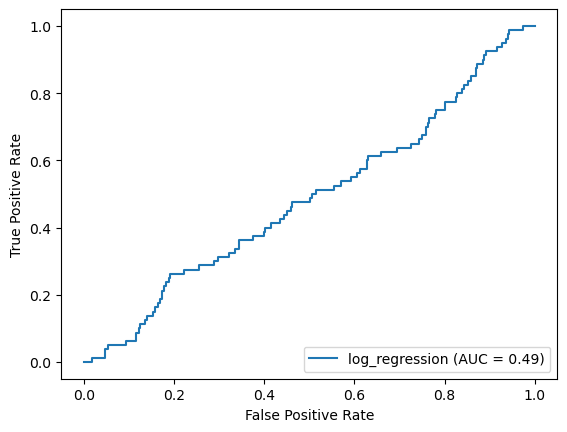

In [700]:
test_config = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': StandardScaler(),
        'use_bureau_and_balance': True,
        'use_previous_applications': False
    },
     'balancing': {
        'should_oversample': True,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42
    }
}

train('log_regression', config=test_config, dev_mode=True)

# Experiments
## Dummy classifier

Set the baseline with the Dummy Classifier

Training the model
Loading application_train ...


2023/11/15 10:24:13 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '99efc56521ce44b68edbd0288454132d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Loading Done.
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2023/11/15 10:24:15 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023/11/15 10:24:16 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/11/15 10:24:18 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow Data

-------------------------
ROC AUC: 0.5
Accuracy: 0.92
Fbeta score(b=10): 0.0
Classification report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56619
           1       0.00      0.00      0.00      4884

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503

-------------------------
execution time: 8.94 seconds 



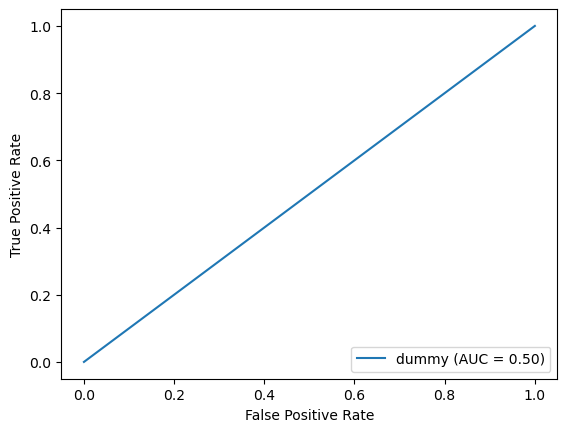

In [515]:
train('dummy', config={'strategy': 'prior'}, dev_mode=False)

TODO: explanation

## Logistic Regression

We will start with the most simple configuration.

In [576]:
# Set the experiment
mlflow.set_experiment("Logistic Regression")

# Track models automatically
mlflow.sklearn.autolog()

In [663]:
config = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': StandardScaler(),
        'use_bureau_and_balance': False,
        'use_previous_applications': False
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42
    }
}

In [535]:
# test on sample
config['balancing']['should_oversample'] = True
config['balancing']['with_categorical'] = True

train('log_regression', config, dev_mode=True)

2023/11/15 11:00:09 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/11/15 11:00:09 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2023/11/15 11:00:09 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


Training the model
Loading application_train ...
Loading Done.
Train shape: (800, 121)
Valid shape: (800,)
Start pipeline fit and transform
[Pipeline] ........... (step 1 of 7) Processing cleaner, total=   0.0s
[Pipeline] . (step 2 of 7) Processing feature_extractor, total=   0.0s
[Pipeline] ........... (step 3 of 7) Processing imputer, total=   0.0s
[Pipeline] ............ (step 4 of 7) Processing scalar, total=   0.0s


2023/11/15 11:00:10 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///Users/natche/Jupiter/Project%207/mlruns/972159027913578879/6a92fa47e6664e7490737cc069bfcc52/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.
2023/11/15 11:00:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 6a92fa47e6664e7490737cc069bfcc52. Failed operations: [MlflowException("The run 6a92fa47e6664e7490737cc069bfcc52 must be in \'active\' lifecycle_stage."), MlflowException("The run 6a92fa47e6664e7490737cc069bfcc52 must be in \'active\' lifecycle_stage.")]')]
2023/11/15 11:00:10 WARNING mlflow.utils.autologging_utils: MLflow autologging en

[Pipeline] .......... (step 5 of 7) Processing smote_nc, total=   1.3s
[Pipeline] ........... (step 6 of 7) Processing encoder, total=   0.0s


2023/11/15 11:00:11 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/models/signature.py:212: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2023/11/15 11:00:12 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have 

[Pipeline] ........ (step 7 of 7) Processing classifier, total=   1.5s
-------------------------
ROC AUC: 0.5


MlflowException: The run 6a92fa47e6664e7490737cc069bfcc52 must be in 'active' lifecycle_stage.

### Baseline

In [584]:
mlflow.end_run()

Training the model
Loading application_train ...
Loading Done.
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2023/11/20 14:55:27 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('imputer',
                 ApplicationImputer(cat_imputer=SimpleImputer(strategy='most_frequent'),
                                    num_imputer=SimpleImputer(strategy='median'))),
                ('scalar', ApplicationScaler(scaler=StandardScaler())),
                ('encoder', ApplicationEncoder())],
         verbose=True)), ('class...`
2023/11/20 14:55:29 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


[Pipeline] ........... (step 1 of 5) Processing cleaner, total=   0.7s
[Pipeline] . (step 2 of 5) Processing feature_extractor, total=   0.0s
[Pipeline] ........... (step 3 of 5) Processing imputer, total=   2.1s
[Pipeline] ............ (step 4 of 5) Processing scalar, total=   0.3s
[Pipeline] ........... (step 5 of 5) Processing encoder, total=   1.2s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   4.3s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.9s


/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023/11/20 14:55:44 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/11/20 14:55:47 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/11/20 14:55:48 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow Data

TN: 56619, FP: 0, FN: 4884, TP: 0
48840
-------------------------
AUC: 0.5
Custom: 0.79
Recall: 0.0
Precision: 0.0
F beta 10: 0.0
Accuracy: 0.92
Classification report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56619
           1       0.00      0.00      0.00      4884

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503

-------------------------
execution time: 24.51 seconds 



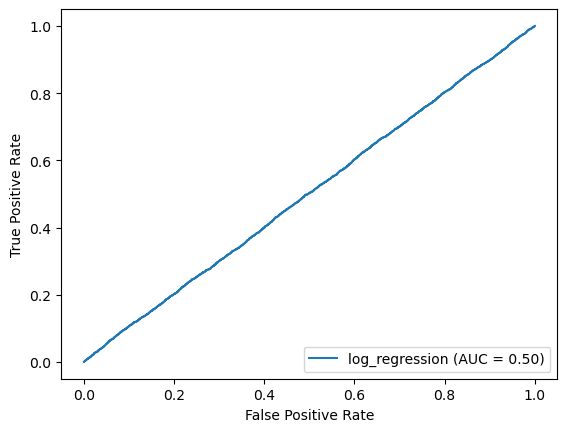

In [703]:
base_config = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': StandardScaler(),
        'use_bureau_and_balance': False,
        'use_previous_applications': False
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42
    }
}

with mlflow.start_run(run_name = 'log_regression_baseline'):
    train('log_regression', config=base_config, dev_mode=False)

mlflow.end_run()

In [702]:
mlflow.end_run()

### With SMOTE

In [665]:
smote_config = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': StandardScaler(),
        'use_bureau_and_balance': False,
        'use_previous_applications': False
    },
     'balancing': {
        'should_oversample': True,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42
    }
}

Training the model
Loading application_train ...
Loading Done.
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform
[Pipeline] ........... (step 1 of 7) Processing cleaner, total=   0.7s
[Pipeline] . (step 2 of 7) Processing feature_extractor, total=   0.0s
[Pipeline] ........... (step 3 of 7) Processing imputer, total=   2.2s
[Pipeline] ............ (step 4 of 7) Processing scalar, total=   0.2s
[Pipeline] ........... (step 5 of 7) Processing encoder, total=   1.2s


2023/11/20 14:57:03 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/11/20 14:57:03 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2023/11/20 14:57:03 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


[Pipeline] ............. (step 6 of 7) Processing smote, total=   3.8s


2023/11/20 14:57:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2023/11/20 14:57:20 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda

[Pipeline] ........ (step 7 of 7) Processing classifier, total=  15.6s


2023/11/20 14:57:24 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2023/11/20 14:57:26 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda

TN: 39733, FP: 16886, FN: 1987, TP: 2897
36756
-------------------------
AUC: 0.65
Custom: 0.6
Recall: 0.59
Precision: 0.15
F beta 10: 0.58
Accuracy: 0.69
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.70      0.81     56619
           1       0.15      0.59      0.23      4884

    accuracy                           0.69     61503
   macro avg       0.55      0.65      0.52     61503
weighted avg       0.89      0.69      0.76     61503

-------------------------
execution time: 30.33 seconds 



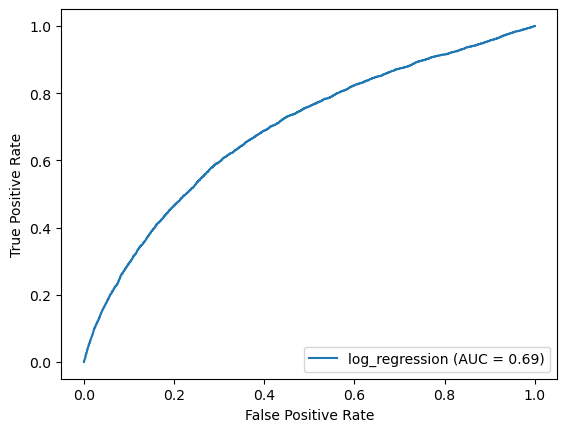

In [704]:
with mlflow.start_run(run_name = 'log_regression_base_smote'):
    train('log_regression', config=smote_config, dev_mode=False)

mlflow.end_run()

### With SMOTENC

In [667]:
smotenc_config = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': StandardScaler(),
        'use_bureau_and_balance': False,
        'use_previous_applications': False
    },
     'balancing': {
        'should_oversample': True,
        'with_categorical': True
    },
    'model_params': {
        'random_state': 42
    }
}

Training the model
Loading application_train ...
Loading Done.
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform
[Pipeline] ........... (step 1 of 7) Processing cleaner, total=   0.7s
[Pipeline] . (step 2 of 7) Processing feature_extractor, total=   0.0s
[Pipeline] ........... (step 3 of 7) Processing imputer, total=   2.2s
[Pipeline] ............ (step 4 of 7) Processing scalar, total=   0.2s


2023/11/17 11:56:53 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/11/17 11:56:53 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2023/11/17 11:56:53 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


[Pipeline] .......... (step 5 of 7) Processing smote_nc, total= 3.4min
[Pipeline] ........... (step 6 of 7) Processing encoder, total=   2.4s


2023/11/17 12:00:28 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2023/11/17 12:00:33 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda

[Pipeline] ........ (step 7 of 7) Processing classifier, total=  16.8s


2023/11/17 12:00:36 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2023/11/17 12:00:38 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda

-------------------------
ROC AUC: 0.64
Accuracy: 0.76
Fbeta score(b=10): 0.47
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.79      0.86     56619
           1       0.16      0.48      0.25      4884

    accuracy                           0.76     61503
   macro avg       0.56      0.64      0.55     61503
weighted avg       0.88      0.76      0.81     61503

-------------------------
execution time: 232.67 seconds 



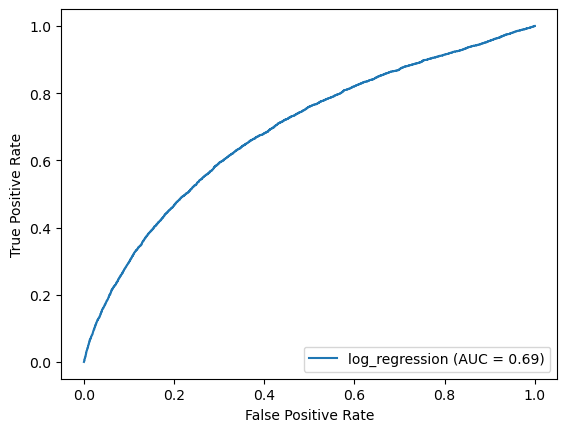

In [668]:
with mlflow.start_run(run_name = 'log_regression_base_smotenc'):
    train('log_regression', config=smotenc_config, dev_mode=False)

mlflow.end_run()

### Add bureau and balance

Training the model
Loading application_train ...
Loading Done.
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform
[Pipeline] ........... (step 1 of 8) Processing cleaner, total=   0.7s
[Pipeline] . (step 2 of 8) Processing feature_extractor, total=   0.0s
shape before  (246008, 128)
new shape after merge (246008, 244)
[Pipeline]  (step 3 of 8) Processing merge_bureau_and_balance, total=   0.2s
[Pipeline] ........... (step 4 of 8) Processing imputer, total=   4.6s
[Pipeline] ............ (step 5 of 8) Processing scalar, total=   0.4s
[Pipeline] ........... (step 6 of 8) Processing encoder, total=   1.3s


2023/11/17 12:01:27 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/11/17 12:01:27 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2023/11/17 12:01:27 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


[Pipeline] ............. (step 7 of 8) Processing smote, total=   4.7s


2023/11/17 12:01:46 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2023/11/17 12:01:51 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda

[Pipeline] ........ (step 8 of 8) Processing classifier, total=  21.6s
shape before  (61503, 128)
new shape after merge (61503, 244)


2023/11/17 12:01:55 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


shape before  (61503, 128)
new shape after merge (61503, 244)


2023/11/17 12:01:58 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


-------------------------
ROC AUC: 0.63
Accuracy: 0.69
Fbeta score(b=10): 0.55
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.70      0.80     56619
           1       0.14      0.56      0.22      4884

    accuracy                           0.69     61503
   macro avg       0.54      0.63      0.51     61503
weighted avg       0.88      0.69      0.76     61503

-------------------------
execution time: 53.76 seconds 



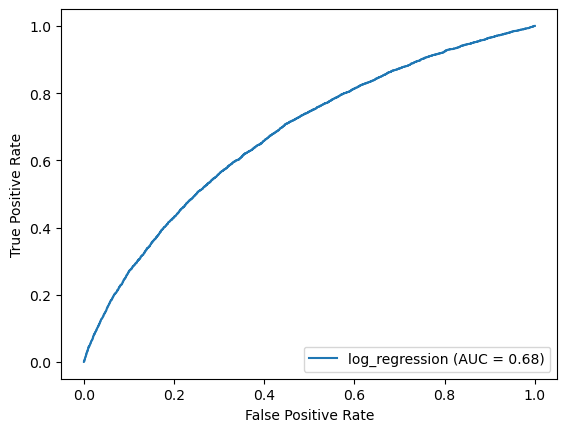

In [669]:
with_bureau_config = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': StandardScaler(),
        'use_bureau_and_balance': True,
        'use_previous_applications': False
    },
     'balancing': {
        'should_oversample': True,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42
    }
}
with mlflow.start_run(run_name = 'log_regression_with_bureau'):
    train('log_regression', config=with_bureau_config, dev_mode=False)
mlflow.end_run()

### Add previous applications

Training the model
Loading application_train ...
Loading Done.
Train shape: (246008, 121)
Valid shape: (246008,)
prev app shape (338857, 237)
Start pipeline fit and transform
[Pipeline] ........... (step 1 of 9) Processing cleaner, total=   0.7s
[Pipeline] . (step 2 of 9) Processing feature_extractor, total=   0.0s
shape before  (246008, 128)
new shape after merge (246008, 244)
[Pipeline]  (step 3 of 9) Processing merge_bureau_and_balance, total=   0.2s
shape before  (246008, 244)
new shape after merge (246008, 481)
[Pipeline]  (step 4 of 9) Processing merge_previous_applications, total=   0.4s
[Pipeline] ........... (step 5 of 9) Processing imputer, total=  10.9s
[Pipeline] ............ (step 6 of 9) Processing scalar, total=   1.2s
[Pipeline] ........... (step 7 of 9) Processing encoder, total=   2.1s


2023/11/17 12:02:50 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/11/17 12:02:50 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2023/11/17 12:02:50 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


[Pipeline] ............. (step 8 of 9) Processing smote, total=   8.1s


2023/11/17 12:03:24 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2023/11/17 12:03:31 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda

[Pipeline] ........ (step 9 of 9) Processing classifier, total=  35.5s
shape before  (61503, 128)
new shape after merge (61503, 244)
shape before  (61503, 244)
new shape after merge (61503, 481)


2023/11/17 12:03:37 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


shape before  (61503, 128)
new shape after merge (61503, 244)
shape before  (61503, 244)
new shape after merge (61503, 481)


2023/11/17 12:03:42 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


-------------------------
ROC AUC: 0.63
Accuracy: 0.7
Fbeta score(b=10): 0.54
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.72      0.82     56619
           1       0.14      0.55      0.23      4884

    accuracy                           0.70     61503
   macro avg       0.55      0.63      0.52     61503
weighted avg       0.88      0.70      0.77     61503

-------------------------
execution time: 92.77 seconds 



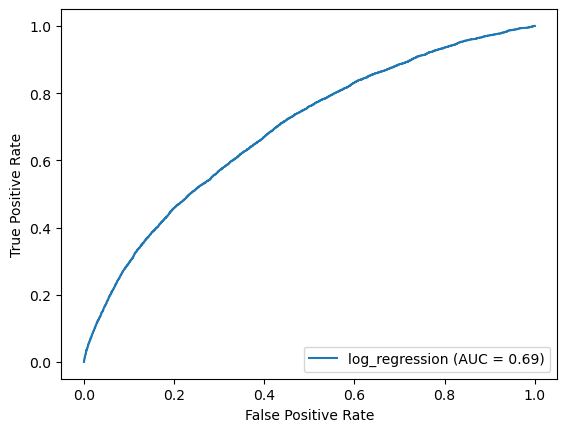

In [670]:
with_prev_app_config = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': StandardScaler(),
        'use_bureau_and_balance': True,
        'use_previous_applications': True
    },
     'balancing': {
        'should_oversample': True,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42
    }
}
with mlflow.start_run(run_name = 'log_regression_with_prev_app'):
    train('log_regression', config=with_prev_app_config, dev_mode=False)
mlflow.end_run()

In [616]:
mlflow.end_run()